In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import wandb
from custom_datasets import dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torchmetrics

wandb_api.login()
api = wandb.Api()
run_name = "3uegu1ye"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [5]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

model_script = run.file("model_script.txt")
model_script = model_script.download(root=root_path, replace=True)
model_script.seek(0)

datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path, replace=True)
datamodule_script.seek(0)

checkpoint = run.file("last.ckpt")
checkpoint.download(root=root_path, replace=True)

model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
model_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)
with open(model_script.name, "r") as file:
    exec(file.read())
with open(datamodule_script.name, "r") as file:
    exec(file.read())


class PredictModel(eval(model_name)):
    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = None):
        if len(batch) == 2:
            return self(batch[0])
        return self(batch)


In [4]:
dm = eval(datamodule_name)(config=config, repo_path=repo_path)
model = PredictModel.load_from_checkpoint(
    root_path / checkpoint.name, config=run.config
)
dm.prepare_data()
dm.setup(stage="validate")
validation_dataloader = dm.val_dataloader()
trainer = pl.Trainer(devices="auto", accelerator="auto")
images, labels = next(iter(validation_dataloader))
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.FloatTensor(dm.targets)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

In [6]:
print(
    f"COSINE SIMILARITY: {torchmetrics.CosineSimilarity(reduction='mean')(predictions, torch.FloatTensor(dm.targets))}"
)
print(
    f"R2 SCORE: {torchmetrics.R2Score(num_outputs=23)(predictions, torch.FloatTensor(dm.targets))}"
)
print(
    f"SMAPE: {torchmetrics.SymmetricMeanAbsolutePercentageError()(predictions, torch.FloatTensor(dm.targets))}"
)
print(
    f"MAPE: {torchmetrics.MeanAbsolutePercentageError()(predictions, torch.FloatTensor(dm.targets))}"
)
print(
    f"MAE: {torchmetrics.MeanAbsoluteError()(predictions, torch.FloatTensor(dm.targets))}"
)
print(f"LOSS: {nn.L1Loss()(predictions, torch.FloatTensor(dm.targets))}")


COSINE SIMILARITY: 0.991187572479248
R2 SCORE: 0.814394474029541
SMAPE: 0.14591851830482483
MAPE: 172.86228942871094
MAE: 0.048188015818595886
LOSS: 0.048188015818595886


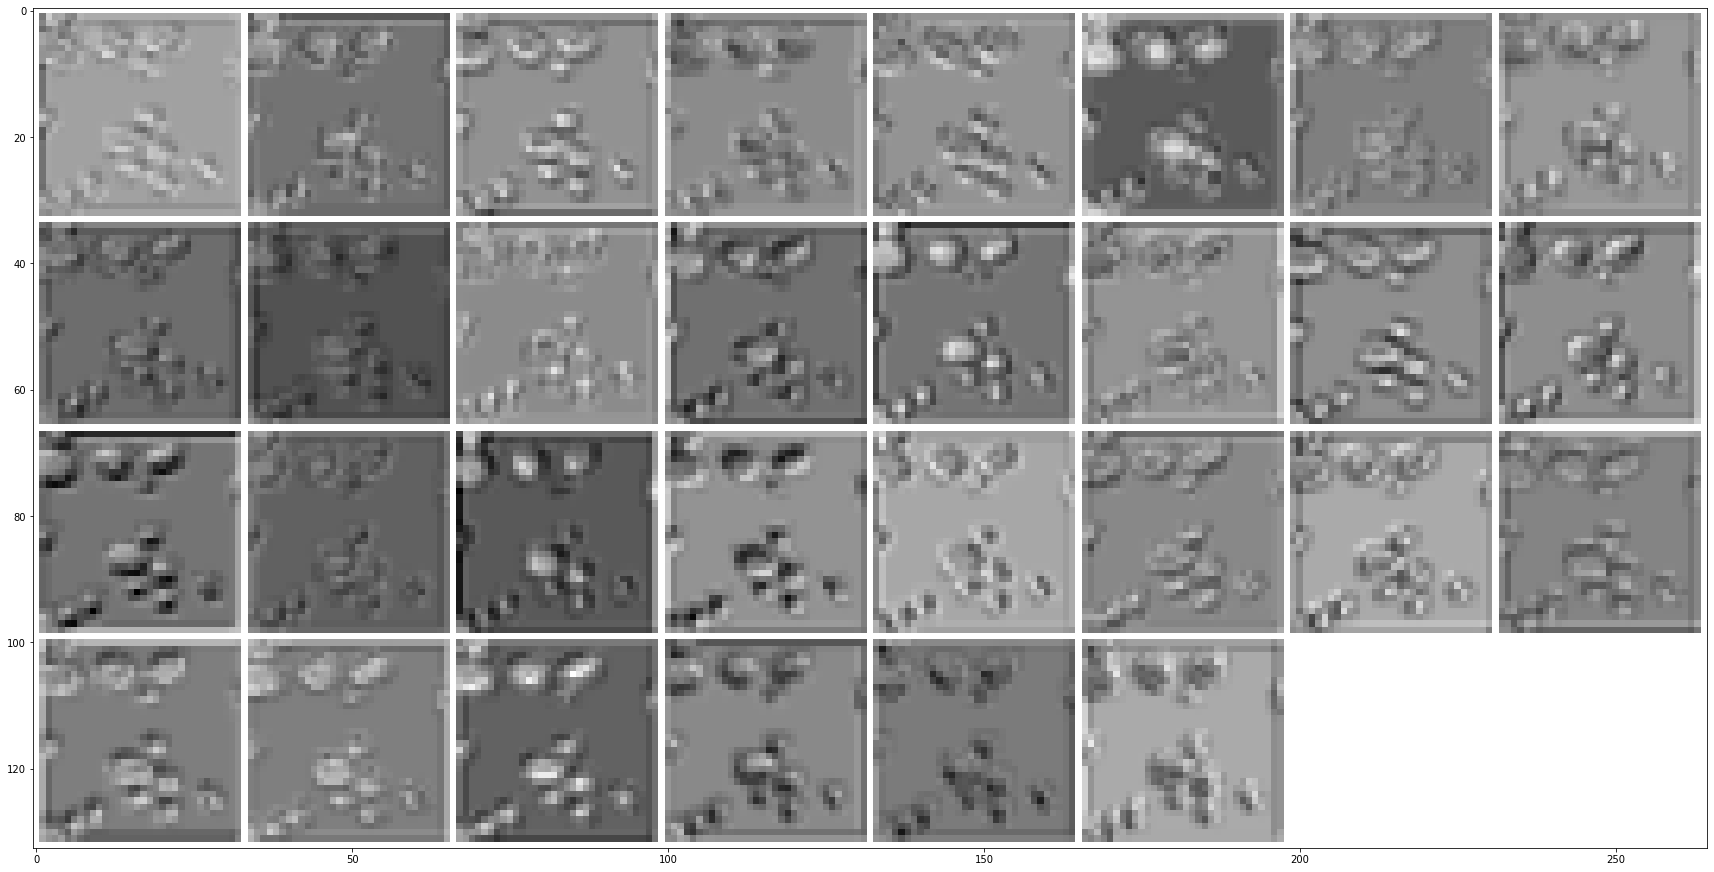

In [6]:
save_output = training.SaveOutput()
handle = model.conv_layers[3].register_forward_hook(save_output)
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:30]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


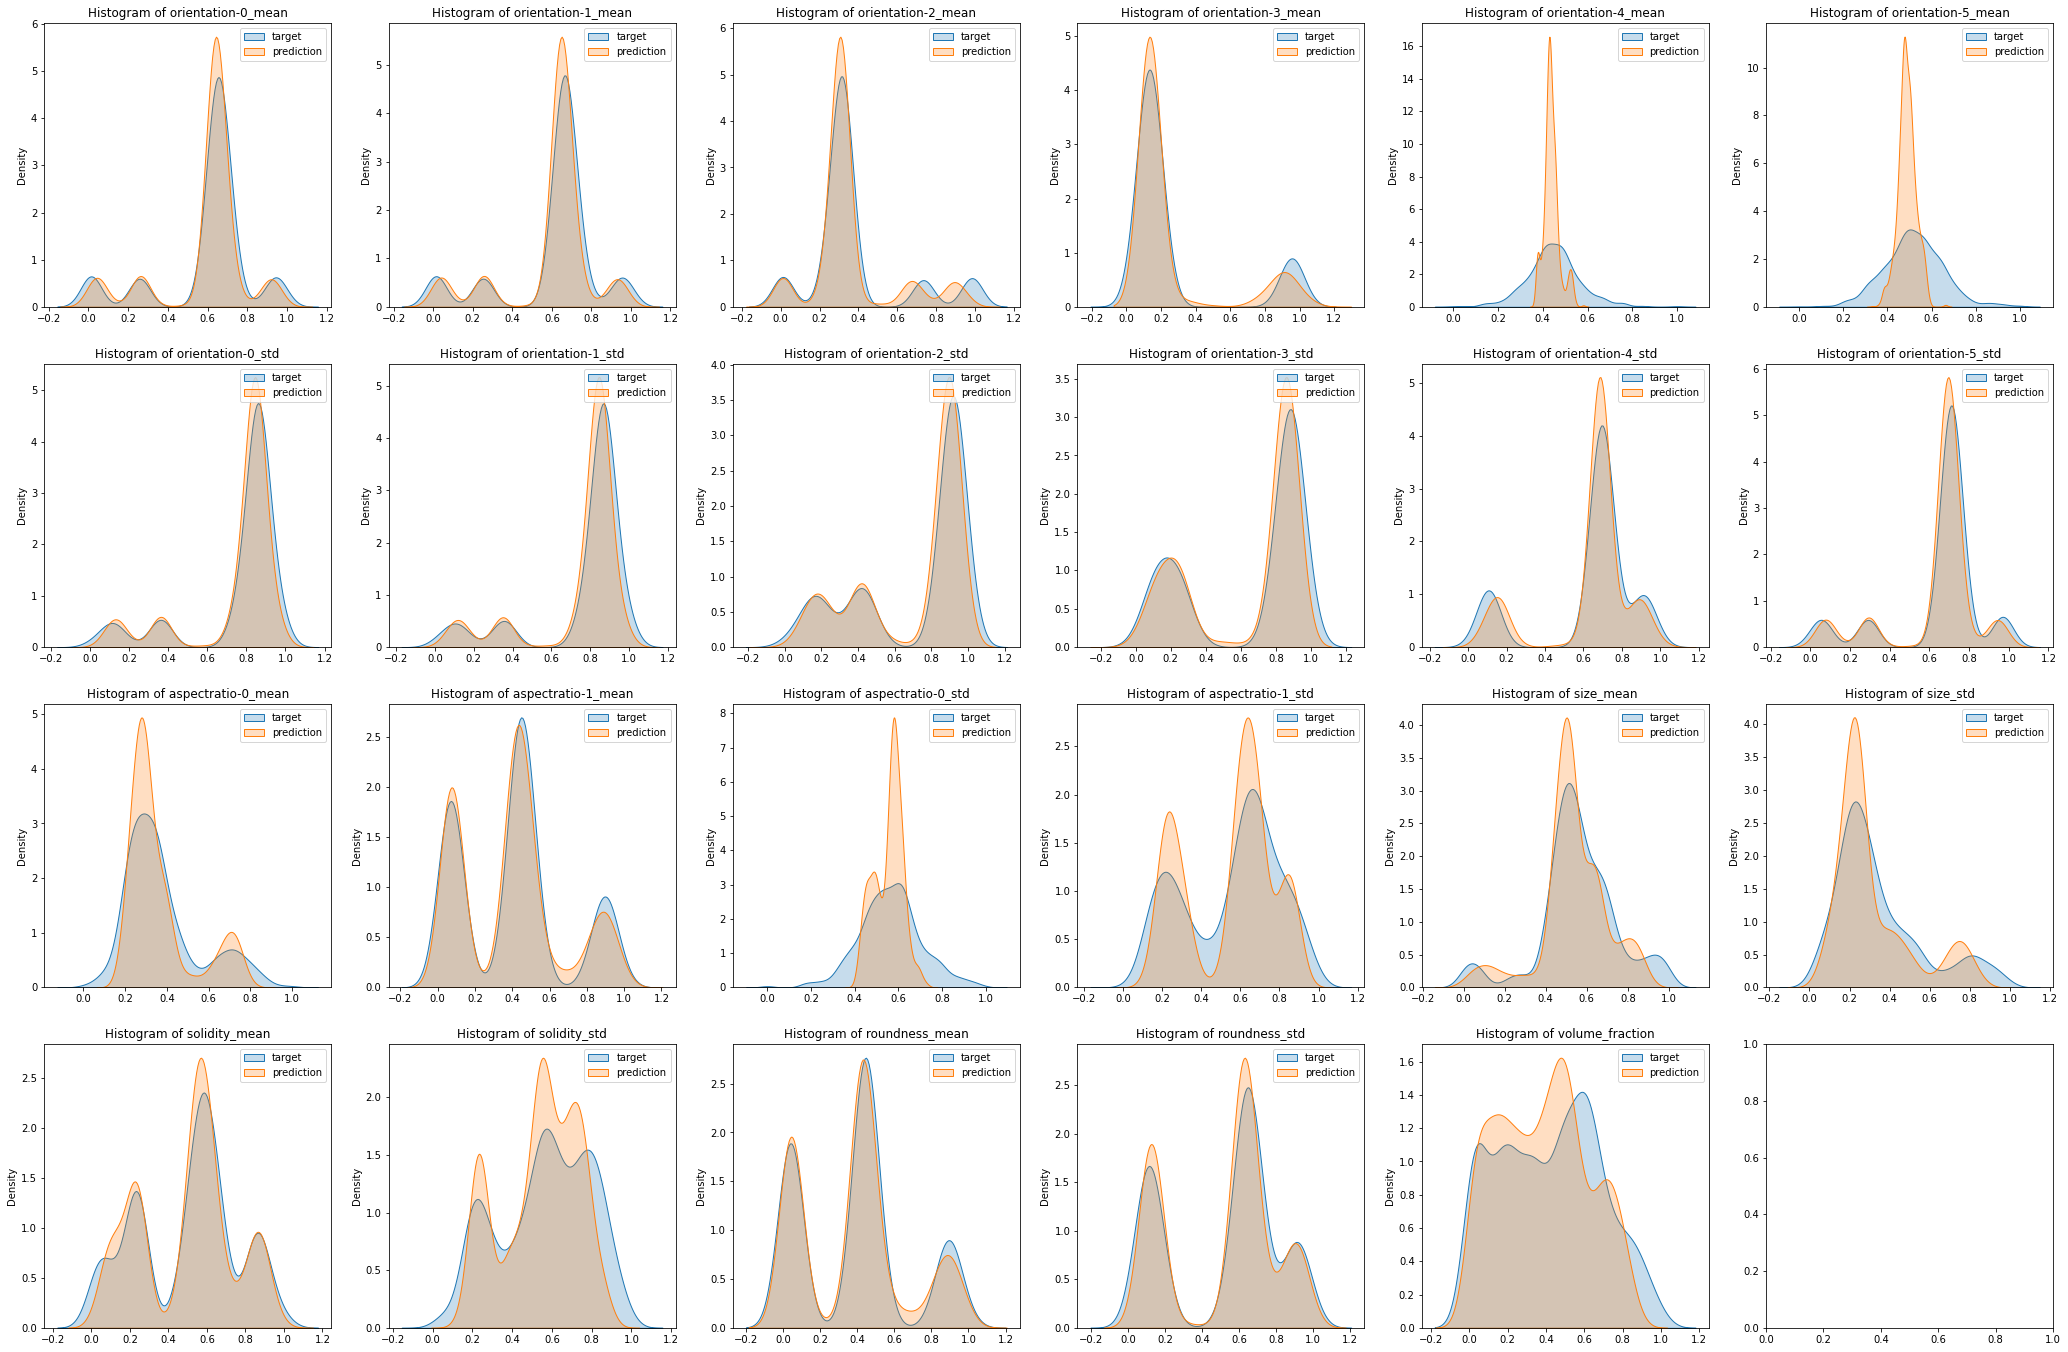

In [8]:
fig = plotting.plot_hist(
    targets.cpu().numpy(),
    predictions.cpu().numpy(),
    nb_hist_per_line=6,
    columns=dm.fabrics_df.columns[1:-1],
)


In [9]:
fabrics_photos_along_x = dm.fabrics_df.copy()
fabrics_photos_along_x["photos"] = dm.fabrics_df["photos"].apply(
    dataframe_reformat.get_path_image_along_axis, args=("x")
)
fabrics_photos_along_y = dm.fabrics_df.copy()
fabrics_photos_along_y["photos"] = dm.fabrics_df["photos"].apply(
    dataframe_reformat.get_path_image_along_axis, args=("y")
)
fabrics_photos_along_z = dm.fabrics_df.copy()
fabrics_photos_along_z["photos"] = dm.fabrics_df["photos"].apply(
    dataframe_reformat.get_path_image_along_axis, args=("z")
)

x_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_x, normalization=False, transform=dm.transform
)
y_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_y, normalization=False, transform=dm.transform
)
z_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_z, normalization=False, transform=dm.transform
)
print(f"Length x set: {len(x_dataset)}")
print(f"Length y set: {len(y_dataset)}")
print(f"Length z set: {len(z_dataset)}")
x_dataloader = DataLoader(
    x_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    **kwargs,
)
y_dataloader = DataLoader(
    y_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    **kwargs,
)
z_dataloader = DataLoader(
    z_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    **kwargs,
)


Length x set: 1800
Length y set: 1800
Length z set: 1800


In [106]:
reload(training)
errors = (
    pd.DataFrame(
        [
            training.compute_smape(
                predictions,
                targets,
                by="column",
            )
        ],
        columns=dm.fabrics_df.columns[1:-1],
    ).mean()
    * 100
)
predictions = dm.scaler.inverse_transform(
    torch.cat(trainer.predict(model, dataloaders=x_dataloader))
)
errors_x = (
    pd.DataFrame(
        [
            training.compute_smape(
                predictions,
                x_dataset.labels,
                by="column",
            )
        ],
        columns=dm.fabrics_df.columns[1:-1],
    ).mean()
    * 100
)
predictions = dm.scaler.inverse_transform(
    torch.cat(trainer.predict(model, dataloaders=y_dataloader))
)
errors_y = (
    pd.DataFrame(
        [
            training.compute_smape(
                predictions,
                y_dataset.labels,
                by="column",
            )
        ],
        columns=dm.fabrics_df.columns[1:-1],
    ).mean()
    * 100
)
predictions = dm.scaler.inverse_transform(
    torch.cat(trainer.predict(model, dataloaders=z_dataloader))
)
errors_z = (
    pd.DataFrame(
        [
            training.compute_smape(
                predictions,
                z_dataset.labels,
                by="column",
            )
        ],
        columns=dm.fabrics_df.columns[1:-1],
    ).mean()
    * 100
)


tensor([0.1817, 0.1836, 0.2258, 1.4237, 1.4917, 1.4277, 0.1262, 0.1337, 0.1752,
        0.1038, 0.0933, 0.1490, 0.0075, 0.0252, 0.0163, 0.0300, 0.0295, 0.0681,
        0.0102, 0.0881, 0.0485, 0.0523, 0.1294])


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(


Predicting: 0it [00:00, ?it/s]

tensor([0.1244, 0.1251, 0.1584, 1.3512, 1.5463, 1.4686, 0.0751, 0.0792, 0.1225,
        0.0709, 0.0729, 0.0912, 0.0069, 0.0201, 0.0153, 0.0259, 0.0287, 0.0645,
        0.0087, 0.0841, 0.0390, 0.0428, 0.1268])


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(


Predicting: 0it [00:00, ?it/s]

/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not NoneType

<AxesSubplot:>

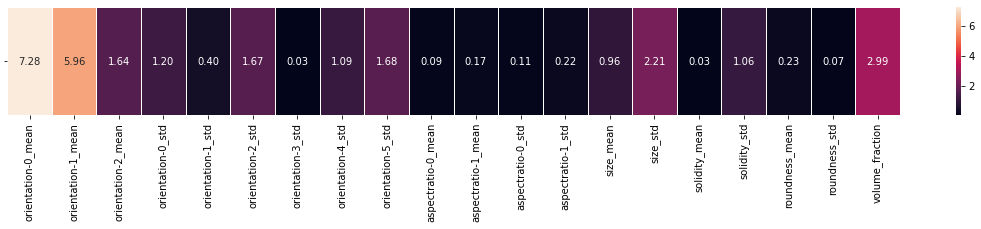

In [21]:
import seaborn as sns

fig = plt.figure(figsize=(20, 2))
sns.heatmap(
    errors.abs()
    .to_frame("")
    .transpose()
    .drop(
        labels=["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"],
        axis=1,
    ),
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)

# plt.savefig("../images/heatmap_average_error.jpg", transparent=False)


<AxesSubplot:>

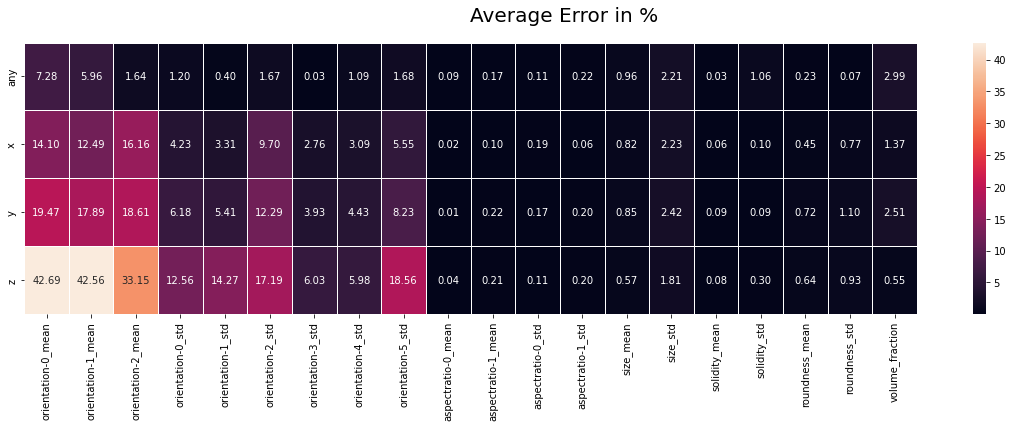

In [75]:
errors_df = pd.DataFrame(
    [errors, errors_x, errors_y, errors_z], index=["any", "x", "y", "z"]
).abs()
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Average Error in %", fontsize=20)
sns.heatmap(
    errors_df.drop(
        labels=["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"],
        axis=1,
    ),
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<AxesSubplot:>

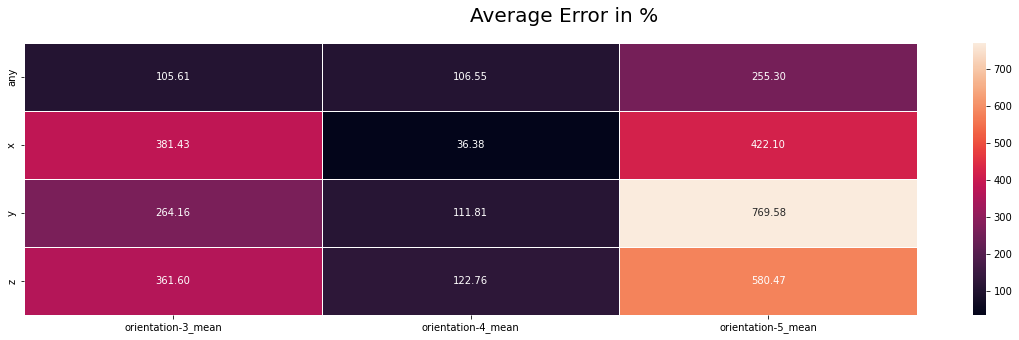

In [76]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Average Error in %", fontsize=20)
sns.heatmap(
    errors_df.loc[
        :, ["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"]
    ],
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)
